<a href="https://colab.research.google.com/github/hpatel1398/het-patel/blob/master/ProjectCodeSem3%264.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [33]:
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS =100
PREVIEW_COLS = 50
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE =10

# Configuration
DATA_PATH = '/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL'
EPOCHS =150
BATCH_SIZE =8
BUFFER_SIZE = 60000

In [34]:
print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [35]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

Looking for file: /content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL/training_data_96_96.npy


In [36]:
#imagePaths = [os.path.join(path, f) for f in os.listdir(path)]
#if DATA_PATH + '.DS_Store' in imagePaths:
  #  imagePaths.remove(DATA_PATH + '.DS_Store')

In [37]:
# creating data for training  and preprocessing  image
if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Loading previous training pickle...


In [38]:
#deep learning model to generate new data
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [39]:
#copy extra deep learning model to generate new data
#def build_generator1(seed_size, channels):
seed_size  = 10
channels = 3
model = Sequential()

model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
model.add(Reshape((4,4,256)))

model.add(UpSampling2D())
model.add(Conv2D(256,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

model.add(UpSampling2D())
model.add(Conv2D(256,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

# Output resolution, additional upsampling
model.add(UpSampling2D())
model.add(Conv2D(128,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

if GENERATE_RES>1:
  model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

# Final CNN layer
model.add(Conv2D(channels,kernel_size=3,padding="same"))
model.add(Activation("tanh"))
print(model.summary())
    #return model.summary()

#build_generator1

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              45056     
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_17 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 8, 8, 256)        

In [41]:
#deep learning model to evaluate the generetion process
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [42]:
#saving image which are generated 
def save_images(cnt,noise):
  if cnt==49:
  
              generated_images = generator.predict(noise)

              generated_images = 0.5 * generated_images + 0.5


            
              im2 = Image.fromarray(generated_images[[0]][0, :, :, 0])

              im2 = im2.resize((240, 240), Image.ANTIALIAS)

              for pt in range(1200):
                      plt.imsave('/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL/'+'epoch_'+str(cnt)+"_image_"+str(pt)+'.jpeg',generated_images[[pt]][0, :, :, 0])

  else:
    print("it is now on epoch ",cnt)


generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

#plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

tf.Tensor([[0.4998612]], shape=(1, 1), dtype=float32)


In [43]:
#to get loss of discrimination model
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [44]:
#to get loss of generator model
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [45]:
#genearation and discrimination  loss parameter at each steps 
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [46]:
#model training for gan output
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

Epoch 1, gen loss=4.234986782073975,disc loss=0.11888787895441055, {hms_string(epoch_elapsed)}
it is now on epoch  0
Epoch 2, gen loss=6.022444725036621,disc loss=0.18765954673290253, {hms_string(epoch_elapsed)}
it is now on epoch  1
Epoch 3, gen loss=5.390841960906982,disc loss=0.23333655297756195, {hms_string(epoch_elapsed)}
it is now on epoch  2
Epoch 4, gen loss=5.532083988189697,disc loss=0.6055492758750916, {hms_string(epoch_elapsed)}
it is now on epoch  3
Epoch 5, gen loss=4.7635931968688965,disc loss=0.9181331396102905, {hms_string(epoch_elapsed)}
it is now on epoch  4
Epoch 6, gen loss=3.856656551361084,disc loss=1.2424496412277222, {hms_string(epoch_elapsed)}
it is now on epoch  5
Epoch 7, gen loss=3.815516948699951,disc loss=1.2131273746490479, {hms_string(epoch_elapsed)}
it is now on epoch  6
Epoch 8, gen loss=3.7695508003234863,disc loss=1.3124055862426758, {hms_string(epoch_elapsed)}
it is now on epoch  7
Epoch 9, gen loss=3.804441213607788,disc loss=1.2493747472763062, {

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [63]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [64]:
train = get_training_data('/content/drive/MyDrive/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


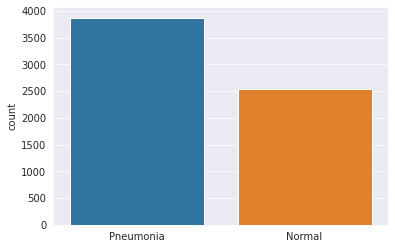

In [65]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

Text(0.5, 1.0, 'NORMAL')

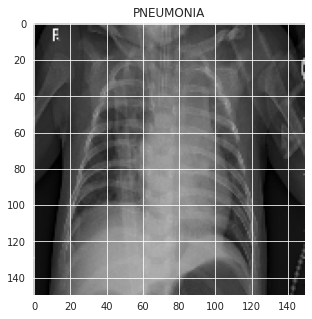

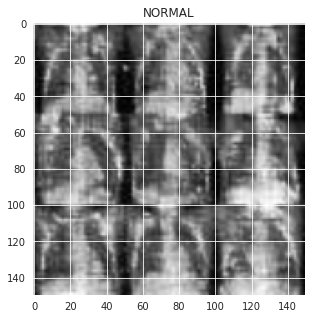

In [66]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [67]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [68]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [69]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [70]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [71]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_34 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_18 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_35 (Bat  (None, 75, 75, 64)      

In [72]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [78]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 16 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/16
201/201 [==============================] - 14s 70ms/step - loss: 0.0854 - accuracy: 0.9727 - val_loss: 1.3459 - val_accuracy: 0.5625 - lr: 2.4300e-06
Epoch 2/16
201/201 [==============================] - 14s 69ms/step - loss: 0.0773 - accuracy: 0.9737 - val_loss: 1.8471 - val_accuracy: 0.5625 - lr: 2.4300e-06
Epoch 3/16
201/201 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9790
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.
201/201 [==============================] - 14s 70ms/step - loss: 0.0671 - accuracy: 0.9790 - val_loss: 2.2129 - val_accuracy: 0.5000 - lr: 2.4300e-06
Epoch 4/16
201/201 [==============================] - 14s 69ms/step - loss: 0.0779 - accuracy: 0.9713 - val_loss: 2.5782 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 5/16
201/201 [==============================] - 14s 69ms/step - loss: 0.0791 - accuracy: 0.9746 - val_loss: 2.0933 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 6/16
201/201 [==============================

In [79]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 14ms/step - loss: 0.3077 - accuracy: 0.9311
Loss of the model is -  0.30765995383262634
20/20 [==============================] - 0s 13ms/step - loss: 0.3077 - accuracy: 0.9311
Accuracy of the model is -  93.10897588729858 %


In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , np.reshape(val_acc,(16,16)) , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [85]:
#predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [86]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.97      0.95       390
   Normal (Class 1)       0.94      0.87      0.90       234

           accuracy                           0.93       624
          macro avg       0.93      0.92      0.93       624
       weighted avg       0.93      0.93      0.93       624



In [87]:
cm = confusion_matrix(y_test,predictions)
cm

array([[377,  13],
       [ 30, 204]])

In [88]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

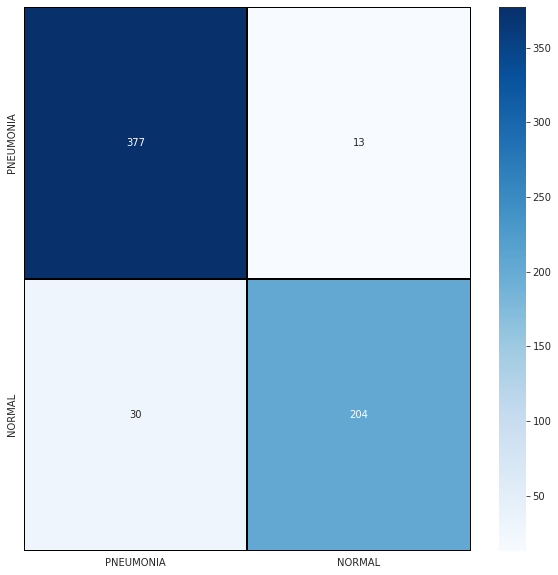

In [89]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [90]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

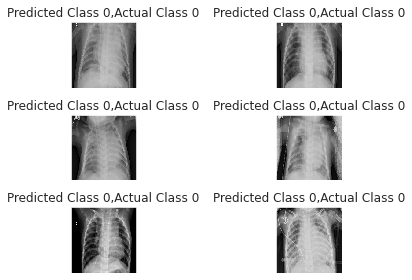

In [91]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

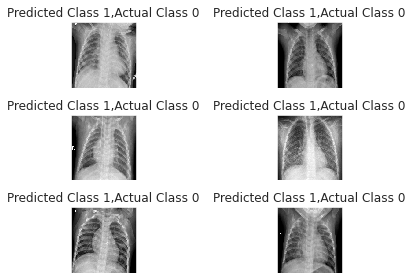

In [92]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [93]:
model.save('/content/drive/MyDrive/model.h5')